# Node Classification using GNN

 - Using the **`Cora` dataset**: a citation network where nodes represent documents. Each node is described by a 1433-dimensional bag-of-words feature vector. Two documents are connected if there exists a citation link between them. The task is to infer the category of each document (7 in total).
 - **Transductive learning**: The ground-truth labels of only a small subset of nodes is given, and the goal is to infer the labels for all the remaining nodes.

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx


2.0.1


In [2]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [3]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset=Planetoid(root='data/Planetoid', name='Cora', 
                  transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### Cora Dataset outlook:
 - 2708 nodes (publications) are there
 - The ground-truth categories of only 140 nodes are given (20 for each class).
 - Node label rate is only 5% (140/2708)
 - Quite similar to the previously used KarateClub network
 - Additionally we have `val_mask` and `test_mask` (for all the nodes actually)
 - `transform=NormalizeFeatures()` for normalization or data augmentation before inputing into the NN. [row-normalize](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fpytorch-geometric.readthedocs.io%2Fen%2Flatest%2Fmodules%2Ftransforms.html%23torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

## Training via an MLP (using no relational knowledge)
In theory, we should be able to infer the category of a document solely based on its content, i.e. its bag-of-words feature representation. 

Here is simple MLP that solely operates on input node features (using shared weights across all nodes):
 - Structure: 2 linear layer with  [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and dropout.
 - The 1433-dimensional feature vector is reduced to a low-dimensional embedding (hidden_channels=16),  while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

In [4]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1=Linear(dataset.num_features, hidden_channels)
        self.lin2=Linear(hidden_channels, dataset.num_classes)
        
    def forward(self, x):
        x=self.lin1(x)
        x=x.relu()
        x=F.dropout(x, p=0.5, training=self.training)
        x=self.lin2(x)
        return x
    
model=MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


### Training MLP: 
 - 
 - cross entropy loss and Adam optimizer
 - A test function is definded to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [5]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, 
                             weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      # Compute the loss solely based on the training nodes.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      # Check against ground-truth labels
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  
      # Derive ratio of correct predictions
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum()) 
      return test_acc

for epoch in range(1, 201):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9609
Epoch: 002, Loss: 1.9558
Epoch: 003, Loss: 1.9485
Epoch: 004, Loss: 1.9413
Epoch: 005, Loss: 1.9297
Epoch: 006, Loss: 1.9266
Epoch: 007, Loss: 1.9124
Epoch: 008, Loss: 1.9024
Epoch: 009, Loss: 1.8985
Epoch: 010, Loss: 1.8849
Epoch: 011, Loss: 1.8753
Epoch: 012, Loss: 1.8684
Epoch: 013, Loss: 1.8483
Epoch: 014, Loss: 1.8465
Epoch: 015, Loss: 1.8115
Epoch: 016, Loss: 1.8143
Epoch: 017, Loss: 1.7900
Epoch: 018, Loss: 1.7985
Epoch: 019, Loss: 1.7639
Epoch: 020, Loss: 1.7383
Epoch: 021, Loss: 1.7229
Epoch: 022, Loss: 1.7452
Epoch: 023, Loss: 1.7000
Epoch: 024, Loss: 1.6855
Epoch: 025, Loss: 1.6691
Epoch: 026, Loss: 1.6479
Epoch: 027, Loss: 1.6284
Epoch: 028, Loss: 1.5960
Epoch: 029, Loss: 1.5562
Epoch: 030, Loss: 1.5396
Epoch: 031, Loss: 1.5488
Epoch: 032, Loss: 1.5224
Epoch: 033, Loss: 1.4665
Epoch: 034, Loss: 1.4885
Epoch: 035, Loss: 1.4399
Epoch: 036, Loss: 1.4035
Epoch: 037, Loss: 1.4265
Epoch: 038, Loss: 1.3742
Epoch: 039, Loss: 1.3742
Epoch: 040, Loss: 1.3391


In [6]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.5740


#### **MLP outlook:**
 - MLP performs rather bad with only about 59% test accuracy.  
 - This is due to heavy overfitting (only having access to a small amount of training nodes, and therefore generalizes poorly to unseen node representations)
 - It also fails to incorporate an important bias into the model: Cited papers are very likely related to the category of a document. That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.

### Training GNN:

In [7]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [8]:
model=GCN(hidden_channels=16)
model.eval()

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)

If the previous & next cell are merged together and run, VSCode gets stuck at 'reconnecting kernel...', everytime. 

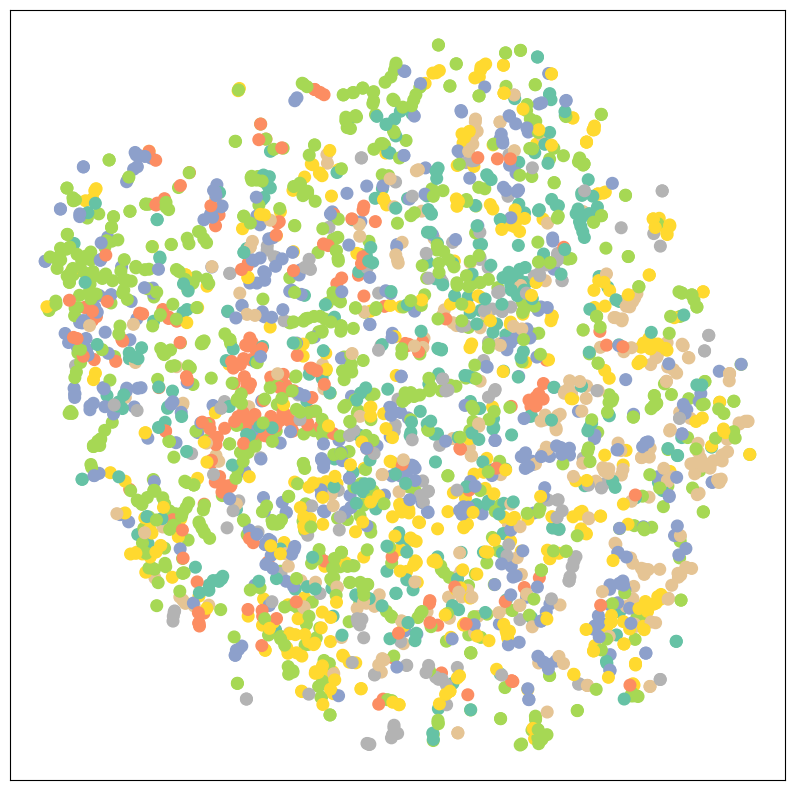

In [9]:
out=model(data.x, data.edge_index)
visualize(out, color=data.y)

In [10]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.9465
Epoch: 002, Loss: 1.9419
Epoch: 003, Loss: 1.9363
Epoch: 004, Loss: 1.9290
Epoch: 005, Loss: 1.9199
Epoch: 006, Loss: 1.9140
Epoch: 007, Loss: 1.9079
Epoch: 008, Loss: 1.8992
Epoch: 009, Loss: 1.8876
Epoch: 010, Loss: 1.8764
Epoch: 011, Loss: 1.8656
Epoch: 012, Loss: 1.8626
Epoch: 013, Loss: 1.8460
Epoch: 014, Loss: 1.8329
Epoch: 015, Loss: 1.8225
Epoch: 016, Loss: 1.8167
Epoch: 017, Loss: 1.7995
Epoch: 018, Loss: 1.7878
Epoch: 019, Loss: 1.7716
Epoch: 020, Loss: 1.7568
Epoch: 021, Loss: 1.7563
Epoch: 022, Loss: 1.7342
Epoch: 023, Loss: 1.7092
Epoch: 024, Loss: 1.7015
Epoch: 025, Loss: 1.6671
Epoch: 026, Loss: 1.6757
Epoch: 027, Loss: 1.6609
Epoch: 028, Loss: 1.6355
Epoch: 029, Loss: 1.6339
Epoch: 030, Loss: 1.6102
Epoch: 031, Loss: 1.5964
Epoch: 032, Loss: 1.5721
Epoch: 033, Loss: 1.5570
Epoch: 034, Loss: 1.5445
Epoch: 035, Loss: 1.5093
Epoch: 036, Loss: 1.4889
Epoch: 037, Loss: 1.4776
Epoch: 038, Loss: 1.4704
Epoch: 039, Loss: 1.4263
Epoch: 040, Loss: 1.3972


In [11]:
test_acc=test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8110


### **GNN outlook:**
 - 81.5% of test accuracy
- This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that *relational information can play a crucial role in obtaining better performance*.

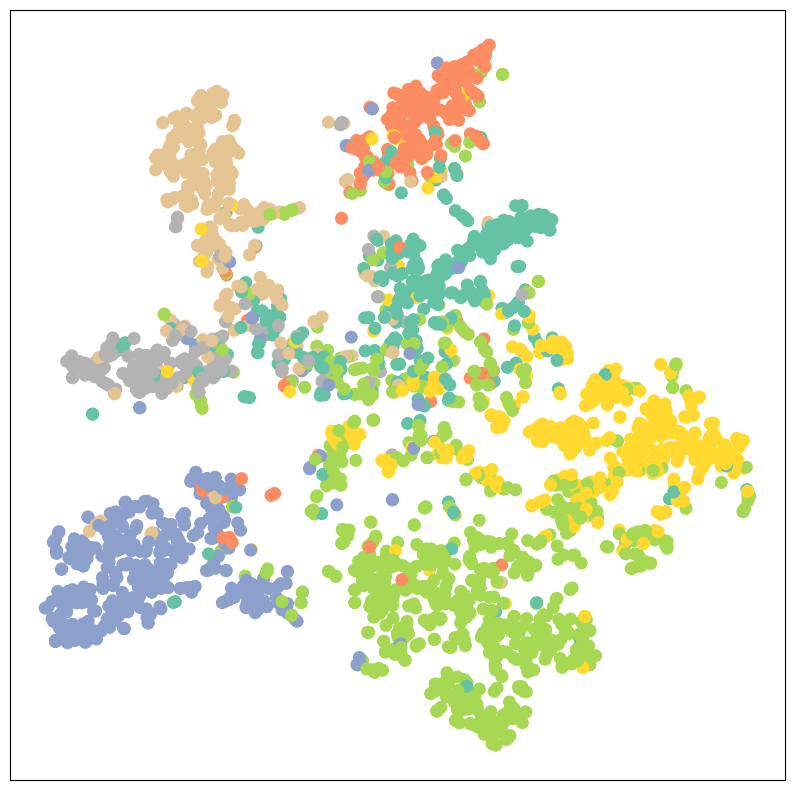

In [12]:
model.eval()
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

- [the concept behind graph attention networks (GAT)](https://www.youtube.com/watch?v=A-yKQamf2Fc)
- [Graph Neural Networks: A Review of Methods and Applications](https://arxiv.org/pdf/1812.08434.pdf) (different variants, according to components used such as __aggregator__ and __updater__)
- Oversmoothing: unfolding to too many layers leads to all the nodes becoming indistinguisable from each other. There are strategies like 
- [How to explain Graph Neural Networks (with XAI)](https://www.youtube.com/watch?v=NvDM2j8Jgvk&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=15)